In [1]:
#Script per modificare il catalogo GLADE_2.4 cambiandone i valori. 
#------------------Import--------------------------------

import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from scipy.optimize import fsolve
from scipy import interpolate
from scipy import integrate
import random
from numpy.random import random

from astropy.cosmology import Planck15
from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.table import Table

from multiprocessing import Pool
import os 
import statistics as stat
import time
from tqdm import tqdm


In [10]:
#Catalogue path
cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
os.chdir(cat_data_path)
#all_event=os.listdir()
#print(all_event)

In [3]:
H0GLOB= 67#67.9 #69
Om0GLOB=0.319
Xi0Glob =1.
#cosmoglob = Planck15
clight = 2.99792458* 10**5#km/s
cosmoflag = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)
import random as rn

#---------------Def Funzioni---------------------
def reflag(dataframe, flag_value, trim_factor):
    newdf=dataframe
    print('setting flag error to {} on glaxies, trimming the number by a factor {}'.format(flag_value, trim_factor))
    nrows=int(newdf.shape[0]/trim_factor)
    print('nrows={}, initial rows={}'.format(nrows,newdf.shape[0]))
    if trim_factor!=1:
        newdf=newdf.sample(nrows)
        print('trimmato')
    newdf['lum_dist_flag']=newdf['lum_dist_flag'].replace(to_replace=2,value=flag_value)
    newdf['lum_dist_flag']=newdf['lum_dist_flag'].replace(to_replace=1,value=flag_value)
    if flag_value==4:
        newdf['lum_dist_flag']=newdf['lum_dist_flag'].replace(to_replace=1,value=flag_value)
        newdf['lum_dist_flag']=newdf['lum_dist_flag'].replace(to_replace=2,value=flag_value)
        newdf['lum_dist_flag']=newdf['lum_dist_flag'].replace(to_replace=3,value=flag_value)
        filename=os.path.join(os.getcwd(), 'GLADE_spectro_flag4'+'_'+str(trim_factor)+'.txt')
    else:
        filename=os.path.join(os.getcwd(), 'GLADE_spectro'+'_'+str(trim_factor)+'.txt')
    print('\nsalvataggio del nuovo catalogo, attendere')
    np.savetxt(filename,newdf.values,fmt='%s')
    print('{} salvato'.format(filename))
    
def cont_flag3(dataframe):
    start=dataframe.shape[0]
    flag3=dataframe.apply(lambda x: True if x['lum_dist_flag'] == 3 else False , axis=1)
    nflag=len(flag3[flag3 == True].index)
    perc=nflag*100/start
    print('Initial hosts={}, number of flag3 host={} that is {}%'.format(start,nflag,perc))
    
def cont_flag2(dataframe):
    start=dataframe.shape[0]
    flag2=dataframe.apply(lambda x: True if x['lum_dist_flag'] == 2 else False , axis=1)
    nflag=len(flag2[flag2 == True].index)
    perc=nflag*100/start
    print('Initial hosts={}, number of flag2 host={} that is {}%'.format(start,nflag,perc))
    
def trimmer(dataframe,trim_factor):
    newdf=dataframe
    print('trimming the catalogue by {} %'.format(trim_factor))
    nrows=int(newdf.shape[0]*(1-trim_factor/100))
    print('nrows={}, initial rows={}'.format(nrows,newdf.shape[0]))
    if trim_factor!=0:
        newdf=newdf.sample(nrows)
        print('trimming')
        filename=os.path.join(os.getcwd(), 'GLADE_trimmed'+'_'+str(trim_factor)+'.txt')
        print('\nsalvataggio del nuovo catalogo, attendere')
        np.savetxt(filename,newdf.values,fmt='%s')
        print('{} salvato'.format(filename))
    

def fake_host(df,ra,dec,dl,z):
    newrow=puppetrow
    newrow['right_ascension_degrees']=ra
    newrow['declination_degrees']=dec
    newrow['dl']=dl
    newrow['app_K_mag']=8
    newrow['pec_vel_correction']=1
    #newrow['err_lum_dist']='NaN'
    newrow['z']=z
    return newrow
def random_displace(ra,dec,dl,delta):
    raout=ra+rn.uniform(-1,1)
    decout=dec+rn.uniform(-1,1)
    dlout=rn.gauss(dl,delta)
    zout=Planck15.H(0).value*dlout/clight
    return raout, decout, dlout, zout

def ra_dec_from_th_phi(theta, phi):
        ra = np.rad2deg(phi)
        dec = np.rad2deg(0.5 * np.pi - theta)
        return ra, dec
    
def th_phi_from_ra_dec(ra, dec):
    theta = 0.5 * np.pi - np.deg2rad(dec)
    phi = np.deg2rad(ra)
    return theta, phi

def z_from_dL(dL_val):
    '''
    Returns redshift for a given luminosity distance dL (in Mpc)'''
    
    func = lambda z :cosmoflag.luminosity_distance(z).value - dL_val
    z = fsolve(func, 0.77)
    return z[0]

def z_from_dcom(dc_val):
    '''
    Returns redshift for a given comoving distance dc (in Mpc)'''
    
    func = lambda z :cosmoflag.comoving_distance(z).value - dc_val
    z = fsolve(func, 0.77)
    return z[0]
#-----------rejection-stuff------------
def sample(g,xmin,xmax):
    x = np.linspace(xmin,xmax,1000000)
    y = g(x)                        # probability density function, pdf
    cdf_y = np.cumsum(y)            # cumulative distribution function, cdf
    cdf_y = cdf_y/cdf_y.max()       # takes care of normalizing cdf to 1.0
    inverse_cdf = interpolate.interp1d(cdf_y,x,fill_value="extrapolate")# this is a function
    #inverse_cdf = np.interp(0,cdf_y,x) #this works but it is not a function
    return inverse_cdf
def return_samples(f,xmin,xmax,N=1000000):
    # let's generate some samples according to the chosen pdf, f(x)
    uniform_samples = random(int(N))       
    required_samples = sample(f,xmin,xmax)(uniform_samples)
    return required_samples
#-----------filler-------------------
def GLADE_inator(iterations):
#for i in tqdm(range(flagship.shape[0])):
#for i in range(iterations):
    i=iterations
    numevent=mynumevent+i
    ngcup=myngcup+i
    GWGC_name='NGC'+ str(ngcup)
    HyperLEDA_name=GWGC_name
    ra_gal=flagship['ra_gal'][i]
    dec_gal=flagship['dec_gal'][i]
    zz=flagship['true_redshift_gal'][i]
    #----------dl----------------------
    #distances are in Mpc/h and are comoving distances. We need luminosity distances and Mpc 
    host_x=flagship['x_gal'][i]/h #restore the right units
    host_y=flagship['y_gal'][i]/h
    host_z=flagship['z_gal'][i]/h

    lum_host_x=host_x*(1+zz)
    lum_host_y=host_y*(1+zz)
    lum_host_z=host_z*(1+zz)
    dl=np.sqrt(lum_host_x**2+lum_host_y**2+lum_host_z**2)
    temp_k_lum=np.random.normal(loc=klum_mean,scale=2*klum_std)
    #----------row to append---------------------
    proxy_row={'numevent':numevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':ra_gal,'declination_degrees':dec_gal,'dl':dl,'z':zz,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':temp_k_lum,'err_app_K_mag':klum_std,
           'lum_dist_flag':3,'pec_vel_correction':0
          }
    #data.append([proxy_row])
    return proxy_row
    #print(proxy_row)
#glade_like.head()

#-----------filler-------------------
def GLADE_inator_volume(iterations):
#for i in tqdm(range(flagship.shape[0])):
#for i in range(iterations):
    i=iterations
    numevent=mynumevent+i
    ngcup=myngcup+i
    GWGC_name='NGC'+ str(ngcup)
    HyperLEDA_name=GWGC_name
    ra_gal=ra_gals[i]
    dec_gal=dec_gals[i]
    #dl=dl_gals[i]
    dc=dc_gals[i]
    #----------z----------------------
    #zz=z_from_dL(dl)
    zz=z_from_dcom(dc)
    dl=cosmoflag.luminosity_distance(zz).value
    #zz=cosmoflag.luminosity_distance(z_min).value
    temp_k_lum=np.random.normal(loc=klum_mean,scale=2*klum_std)
    #----------row to append---------------------
    proxy_row={'numevent':numevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':ra_gal,'declination_degrees':dec_gal,'dl':dl,'z':zz,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':temp_k_lum,'err_app_K_mag':klum_std,
           'lum_dist_flag':3,'pec_vel_correction':0
          }
    return proxy_row

In [4]:
#--------------globals and flags-----------------
nohost=8
clear=1
onebyone=1
#---------------Main-----------------------------
#alcuni appunti sui flag:

#Object type flag: Q the source is from the SDSS-DR12Q catalogue. C: the source is a globular cluster. 
#G:the source is not from the SDSS-DR12Q catalogue and notidentified as a globular cluster

#Luminosity distance measurement flag. 0: the object has neither measured distance nor measured redshift value.
#1: the object has measured redshift value from which we have calculated its distance. 2: the object has measured distance
#value from which we have calculated its redshift. 3: we have replaced the measured photometric redshift with spectroscopic
#redshift from the 2MASS Redshift Survey catalogue,from which we have calculated its distance.

#Velocity correction flag. It indicates whether the peculiar velocity correction was not (’0’) or was (’1’) applied
#when the distance of the object was calculated.

#df = pd.read_csv('TestGLADE.txt', sep=" ", header=None, low_memory=False)
tempdf = pd.read_csv('puppet.txt', sep=" ", header=None, low_memory=False)
df = pd.read_csv('GLADE_2.4.txt', sep=" ", header=None, low_memory=False)
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
df.columns=colnames
tempdf.columns=colnames
puppetrow=tempdf.iloc[0]
ncols=len(df.columns)
nraws=len(df.index)
print("righe={}, colonne={}, shape={} " .format(nraws,ncols,df.shape))

#conteggio eventi tra z1 e z2
#print(df.shape[0])
#z1=0.05
#z2=0.12
#err=0.02
#counterdf=df[df['z'].between(z1-err, z1+err)]
#print(counterdf.shape[0])
#newconter=df[df['z'].between(z2-err, z2+err)]
#print(newconter.shape[0])
#print(len(newconter))


righe=2722493, colonne=22, shape=(2722493, 22) 


In [ ]:

znull=np.where(df.z.notna(),1,0)
dlnull=np.where(df.dl.notna(),1,0)
z_zero=np.count_nonzero(znull==0)
dl_zero=np.count_nonzero(dlnull==0)
print('la colonna z ha {} elementi nulli\nla colonna dl ha {} elementi nulli'.format(z_zero,dl_zero))
dLvals = df[df.dl.notna()]['dl']
print('%s elementi in dLvals'%dLvals.shape[0])
zvals = df[df.z.notna()]['z']
print('%s elementi in z'%zvals.shape[0])


newdf=df[df['z'].notna()]
newdf=newdf[newdf['dl'].notna()]
znull=np.where(newdf.z.notna(),1,0)
dlnull=np.where(newdf.dl.notna(),1,0)
z_zero=np.count_nonzero(znull==0)
dl_zero=np.count_nonzero(dlnull==0)
col=newdf['z']
max_z=col.max()
print('massimo valore redshift: z={}  '.format(max_z))

print('la colonna z ha {} elementi nulli\nla colonna dl ha {} elementi nulli'.format(z_zero,dl_zero))
#print('\n\n\n salvataggio del nuovo catalogo, attendere')
#np.savetxt('GLADE_nonull.txt',newdf.values,fmt='%s')
#print('GLADE_nonull.txt salvato')
    
    


In [ ]:
#reflag(newdf,3,1)

In [ ]:
#cont_flag3(newdf)

In [ ]:
#cont_flag2(newdf)

In [ ]:
#trimmer(newdf,90)

In [ ]:
#-------------Inserimento Fake Hosts--------------------------
#fake_host(df,ra,dec,dl,z)
iteration=10
#----------------GW190412-----------------------
ra=218.4521484375
dec=36.42357364233115
dl=734.121575455142
std=93.28161482151035
z=0.16587940821823915
toadd=fake_host(newdf,ra,dec,dl,z)
newdf=newdf.append(toadd)
#for i in range(iteration):
    #ra0,dec0,dl0,z0 = random_displace(ra,dec,dl,std)
    #toadd=fake_host(newdf,ra0,dec0,dl0,z0)
    #newdf=newdf.append(toadd)
print('1 of 5 done')
#-------------GW190814---------------------------
ra=12.7001953125
dec=-24.87076339473571
dl=240.7344958889034
std=26.05124052395576
z=0.05439548032764159
toadd=fake_host(newdf,ra,dec,dl,z)
newdf=newdf.append(toadd)
#for i in range(iteration):
    #ra0,dec0,dl0,z0 = random_displace(ra,dec,dl,std)
    #toadd=fake_host(newdf,ra0,dec0,dl0,z0)
    #newdf=newdf.append(toadd)
print('2 of 5 done')
#---------------GW190924_021846---------------------
ra=127.265625
dec=16.25709623792208
dl=572.3830413569922 
std=136.682093600127
z=0.1293335645605956
toadd=fake_host(newdf,ra,dec,dl,z)
newdf=newdf.append(toadd)
for i in range(iteration):
    ra0,dec0,dl0,z0 = random_displace(ra,dec,dl,std)
    toadd=fake_host(newdf,ra0,dec0,dl0,z0)
    newdf=newdf.append(toadd)
print('3 of 5 done')    
#-----------------GW190527_092055--------------------------
ra=39.14383561643836
dec=-63.07261938698223
dl=3562.931275516
std=1965.511983689016
z=0.8050668326134269
toadd=fake_host(newdf,ra,dec,dl,z)
#newdf=newdf.append(toadd)
#for i in range(iteration):
    #ra0,dec0,dl0,z0 = random_displace(ra,dec,dl,std)
    #toadd=fake_host(newdf,ra0,dec0,dl0,z0)
    #newdf=newdf.append(toadd)
print('4 of 5 done')

#-----------------GW170817--------------------------
#ra=196.03586373589667 #3.44616 #105.29296875
#dec=-20.841149792255525#-0.408084 #-0.7833651412800737
#dl=34.03408225450563
#std=7.499686641911211
#z=0.0087
#toadd=fake_host(newdf,ra,dec,dl,z)
#newdf=newdf.append(toadd)
#for i in range(iteration):
    #ra0,dec0,dl0,z0 = random_displace(ra,dec,dl,std)
    #toadd=fake_host(newdf,ra0,dec0,dl0,z0)
    #newdf=newdf.append(toadd)
print('5 of 5 done')
#------------------Fake-BS-------------------------
ra=196.03586373589667 #3.44616 #105.29296875
dec=-20.841149792255525#-0.408084 #-0.7833651412800737
dl=20
std=4.595980697842096
z=cosmoglob.H(0).value*dl/clight
toadd=fake_host(newdf,ra,dec,dl,z)
newdf=newdf.append(toadd)
newdf=newdf.tail(6)
#----------------Saving-------------------------------
filename=os.path.join(os.getcwd(), 'GLADE_fakeBS20'+'.txt')
print('Saving new catalogue with host injection, wait...')
np.savetxt(filename,newdf.values,fmt='%s')
print('{} saved!'.format(filename))


# From FlagShip to GLADE-like

In [ ]:
#------------read the flagship-------------------------------------
dat = Table.read('11536.fits', format='fits')
flagship = dat.to_pandas()#all good, is an only text fits
print(flagship.columns)
print(flagship.shape[0])
flagship.head(3)

In [ ]:
z=np.array(flagship['true_redshift_gal'])
ra=np.array(flagship['ra_gal'])
dec=np.array(flagship['dec_gal'])
print('z_min={}, z_max={}'.format(np.min(z),np.max(z)))
print('ra_min={}, ra_max={}'.format(np.min(ra),np.max(ra)))
print('dec_min={}, dec_max={}'.format(np.min(dec),np.max(dec)))
thetamin,phimin=th_phi_from_ra_dec(np.min(ra),np.max(dec))
thetamax,phimax=th_phi_from_ra_dec(np.max(ra),np.min(dec))
print('phi_min={}, phi_max={}'.format(phimin,phimax))
print('theta_min={}, theta_max={}'.format(thetamin,thetamax))

In [ ]:
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['ra_gal', 'dec_gal', 'observed_redshift_gal', 'true_redshift_gal',
       'x_gal', 'y_gal', 'z_gal', 'vx_gal', 'vy_gal', 'vz_gal']
randflagship = pd.DataFrame(columns=colnames)
randflagship.head(3)

In [ ]:
randflagship=flagship.head(5000)
cat_name='GLADE_flagship_5000incr.txt'

In [ ]:
#randflagship=randflagship.append(flagship.sample(5500), ignore_index=True)
#randflagship.to_csv('flagrandsource.txt', header=None, index=None, sep=' ')

In [ ]:
#alcuni appunti sui flag:

#Object type flag: Q the source is from the SDSS-DR12Q catalogue.
#C: the source is a globular cluster. 
#G:the source is not from the SDSS-DR12Q catalogue and notidentified as a globular cluster

#Luminosity distance measurement flag.
#0: the object has neither measured distance nor measured redshift value.
#1: the object has measured redshift value from which we have calculated its distance. 
#2: the object has measured distance value from which we have calculated its redshift. 
#3: we have replaced the measured photometric redshift with spectroscopic redshift 
#from the 2MASS Redshift Survey catalogue,from which we have calculated its distance.

#Velocity correction flag. It indicates whether the peculiar velocity correction was not (’0’)
#or was (’1’) applied when the distance of the object was calculated.


In [5]:
#---------------read Glade-------------------
glade = pd.read_csv('GLADE_2.4.txt', sep=" ", header=None, low_memory=False)
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
glade.columns=colnames
glade.head(5)
klum=np.array(glade['app_K_mag'])
#zglade=np.array(flagship['true_redshift_gal'])

In [6]:
mean_app_B_mag=np.sum(glade['app_B_mag'])/glade.shape[0]
mean_abs_B_mag=np.sum(glade['abs_B_mag'])/glade.shape[0]
mean_app_J_mag=np.sum(glade['app_J_mag'])/glade.shape[0]
mean_app_H_mag=np.sum(glade['app_H_mag'])/glade.shape[0]
mean_app_K_mag=np.sum(glade['app_K_mag'])/glade.shape[0]
print(mean_app_B_mag,mean_abs_B_mag,mean_app_J_mag,mean_app_H_mag,mean_app_K_mag)

10.535271935685417 inf 5.277627146516081 4.923685721873297 4.862867403148511


lum mean=13.334410160003385, lum std=0.7488173704298869


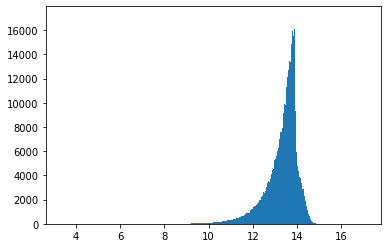

In [7]:
klum = klum[~np.isnan(klum)]
plt.hist(klum,bins='auto')
klum_mean=stat.mean(klum)
klum_std=stat.stdev(klum)
print('lum mean={}, lum std={}'.format(klum_mean,klum_std))

In [8]:
err_app_B_mag=np.sum(glade['err_app_B_mag'])/glade.shape[0]
err_app_J_mag=np.sum(glade['err_app_J_mag'])/glade.shape[0]
err_app_H_mag=np.sum(glade['err_app_H_mag'])/glade.shape[0]
err_app_K_mag=np.sum(glade['err_app_K_mag'])/glade.shape[0]
print(err_app_B_mag,err_app_J_mag,err_app_H_mag,err_app_K_mag)

0.12391253898540787 0.029373865791390466 0.033138621476712704 0.04406159611796981


In [ ]:
h=0.67
mynumevent=int(43495)
myngcup=int(4736)
GWGC_name='NGC'+ str(myngcup)
HyperLEDA_name=GWGC_name
MASS_XSC_name='NaN'
type_flag='G'
proxy_row={'numevent':mynumevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':0,'declination_degrees':0,'dl':0,'z':0,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':klum_mean+4,'err_app_K_mag':klum_std,
           'lum_dist_flag':3,'pec_vel_correction':0
          }

In [ ]:

#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
glade_like = pd.DataFrame(columns=colnames)
#glade_like.columns=colnames
glade_like.head()

In [ ]:
arr=np.arange(0,flagship.shape[0],dtype=int)
data=[]
tmp=[]
start_time = time.time()
with Pool(10) as p:
    tmp=p.map(GLADE_inator, arr)
print("--- %s seconds ---" % (time.time() - start_time))
#glade_like.to_csv(r'GLADE_flagship.txt', header=None, index=None, sep=' ', mode='a')

In [ ]:
glade_like=glade_like.append(tmp, ignore_index=True)
glade_like.tail()

In [ ]:
glade_like.to_csv(cat_name, header=None, index=None, sep=' ')

In [ ]:
del tmp
del data

# Add host to FlaghShip

In [ ]:
myglade = pd.read_csv('GLADE_flagship.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
myglade = pd.DataFrame(columns = colnames)
#myglade.columns=colnames
myglade.head(5)

In [ ]:
glade500 = pd.read_csv(cat_name, sep=" ", header=None, low_memory=False)
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
glade500.columns=colnames

In [ ]:
#GW221007
mynumevent=int(14091027)
myngcup=int(14052268)
GWGC_name='NGC'+ str(myngcup)
HyperLEDA_name=GWGC_name
MASS_XSC_name='NaN'
type_flag='G'
numevent=mynumevent+1
ngcup=myngcup+1
GWGC_name='NGC'+ str(ngcup)
HyperLEDA_name=GWGC_name
ra_gal=22.546875
dec_gal=44.993880150457116
zz=1.7
#----------dl----------------------
dl=13102.8222124438
temp_k_lum=np.random.normal(loc=klum_mean,scale=2*klum_std)
#----------row to append---------------------
proxy_row={'numevent':numevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
       '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
       'right_ascension_degrees':ra_gal,'declination_degrees':dec_gal,'dl':dl,'z':zz,
       'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
       'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
       'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
       'app_K_mag':14,'err_app_K_mag':0,
       'lum_dist_flag':3,'pec_vel_correction':0
      }

In [ ]:
#hostedglade=myglade.append(glade_like, ignore_index=True)
#hostedglade=hostedglade.append(proxy_row, ignore_index=True)
#hostedglade=myglade.append(glade500, ignore_index=True)
hostedglade=glade500.append(proxy_row, ignore_index=True)

In [ ]:
hostedglade=hostedglade.append(proxy_row,ignore_index=True)
hostedglade.tail(10)

In [ ]:
hostedglade.to_csv(cat_name, header=None, index=None, sep=' ')

 # Line of Sight

In [ ]:
tmp_host = pd.read_csv('host_of_GW2218xx.txt', sep=" ", header=None, low_memory=False)
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
tmp_host.columns=colnames
tmp_host.head(25)

In [ ]:
z_host=tmp_host['z']
z_host=np.linspace(1.1,1.3,10)
step=z_host[1]-z_host[0]
print(step)
z_host_min=np.min(z_host)
z_host_max=np.max(z_host)
zmin=0.79
inf_range=z_host_min-zmin
inf_Nsteps=inf_range/step
#print(zmin+inf_Nsteps*step)
zmax=2
sup_range=zmax-z_host_max
sup_Nsteps=sup_range/step
#print(zmax-sup_Nsteps*step)
zinf=np.zeros(int(inf_Nsteps))
zsup=np.zeros(int(sup_Nsteps))
for i in range(int(inf_Nsteps)):
    zinf[i]=z_host_min-step*i
zinf=np.sort(zinf)
#print(zinf)
#if zref not in zinf:
#    zinf=np.append(zinf,zref)
for i in range(int(sup_Nsteps)):
    zsup[i]=z_host_max+step*i
#print(zsup)
zinf=zinf[0:-2]
hold_zinf=list(zinf)
zinf=random.sample(hold_zinf,5)
zinf=np.asarray(zinf)

zsup=zsup[1:]
hold_zsup=list(zsup)
zsup=random.sample(hold_zsup,5)
zsup=np.asarray(zsup)

z_line=np.append(zinf,zsup)
z_line=np.append(z_line,z_host)
z_line=np.sort(z_line)
z_line=np.unique(z_line)
#hold_zs=list(z_line)
#z_line=random.sample(hold_zs,10)
#z_line=np.asarray(z_line)
#if 1.1 not in z_line:
#    z_line=np.append(z_line,1.1)
#z_line=np.sort(z_line)
#z_line=np.unique(z_line)
print(z_line,len(z_line))

In [ ]:
#myglade = pd.read_csv('GLADE_flagship.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
myglade = pd.DataFrame(columns = colnames)
#myglade.columns=colnames
myglade.head(5)

In [ ]:
for i in range(len(z_line)):
    mynumevent=int(0)
    myngcup=int(0)
    GWGC_name='NGC'+ str(myngcup)
    HyperLEDA_name=GWGC_name
    MASS_XSC_name='NaN'
    type_flag='G'
    numevent=mynumevent+i
    ngcup=myngcup+i
    GWGC_name='NGC'+ str(ngcup)
    HyperLEDA_name=GWGC_name
    ra_gal=45.0
    dec_gal=45.0
    zz=z_line[i]
    #----------dl----------------------
    dl=cosmoflag.luminosity_distance(zz).value
    temp_k_lum=np.random.normal(loc=klum_mean,scale=2*klum_std)
    #----------row to append---------------------
    proxy_row={'numevent':numevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':ra_gal,'declination_degrees':dec_gal,'dl':dl,'z':zz,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':14,'err_app_K_mag':0,
           'lum_dist_flag':3,'pec_vel_correction':0
          }
    myglade=myglade.append(proxy_row,ignore_index=True)

In [ ]:
myglade.head(len(z_line))

In [ ]:
myglade.to_csv('GLADE_line18_20_allhost.txt', header=None, index=None, sep=' ')

In [ ]:
myglade.to_csv('GLADE_flagship_angulardisp05_newsig.txt', header=None, index=None, sep=' ')

# Automatic Host Placer

z_min=0.7887375950813293, z_max=2.0129446983337402
ra_min=1.558116673550103e-05, ra_max=89.99999237060547
dec_min=2.9646462280652486e-06, dec_max=89.98294830322266
phi_min=2.7194266749575036e-07, phi_max=1.5707961320877075
theta_min=0.0002976218846182377, theta_max=1.570796275052059

In [ ]:
'''Reading the datasheet of the GWs'''
GW_data_path='/home/rciancarella/DarkSirensStat/data/GW/O3/'
os.chdir(GW_data_path)
with open('GW32xxxx_datasheet.txt','r') as f:
    next(f)
    lines=f.readlines()
    GWs_dl=[]
    GWs_theta=[]
    GWs_phi=[]
    GWs_z=[]
    for x in lines:
        GWs_dl.append(float(x.split('\t')[1]))
        GWs_theta.append(float(x.split('\t')[2]))
        GWs_phi.append(float(x.split('\t')[3]))
        GWs_z.append(float(x.split('\t')[4]))
    #for i in range(len(GW_z)):
        
cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
os.chdir(cat_data_path)
GWs_dl=np.asarray(GWs_dl)
GWs_theta=np.asarray(GWs_theta)
GWs_phi=np.asarray(GWs_phi)
GWs_z=np.asarray(GWs_z)
#--------------from phi, theta to RA DEC the same way as Maggiore---------------------------
GWs_ra=np.zeros(len(GWs_phi))
GWs_dec=np.zeros(len(GWs_theta))
for j in range(len(GWs_phi)):
    GWs_ra[j]=np.rad2deg(GWs_phi[j])
    GWs_dec[j] = np.rad2deg(0.5 * np.pi - GWs_theta[j])
#print(GWs_ra,GWs_dec)

In [ ]:
'''New cat containing only the true hosts'''
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
myglade = pd.DataFrame(columns = colnames)
#myglade.columns=colnames
myglade.head(5)

In [ ]:
for i in range(len(GWs_phi)):
    mynumevent=int(90000000)
    myngcup=int(99000000)
    GWGC_name='NGC'+ str(myngcup)
    HyperLEDA_name=GWGC_name
    MASS_XSC_name='NaN'
    type_flag='G'
    numevent=mynumevent+i
    ngcup=myngcup+i
    GWGC_name='NGC'+ str(ngcup)
    HyperLEDA_name=GWGC_name
    ra_gal=GWs_ra[i]
    dec_gal=GWs_dec[i]
    zz=GWs_z[i]
    #----------dl----------------------
    dl=GWs_dl[i]
    #temp_k_lum=np.random.normal(loc=klum_mean,scale=2*klum_std)
    #----------row to append---------------------
    proxy_row={'numevent':numevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':ra_gal,'declination_degrees':dec_gal,'dl':dl,'z':zz,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':14,'err_app_K_mag':0,
           'lum_dist_flag':3,'pec_vel_correction':0
          }
    myglade=myglade.append(proxy_row,ignore_index=True)
myglade.tail(len(GWs_z)+10)

In [ ]:
myglade.to_csv('host_of_GW32xxxx.txt', header=None, index=None, sep=' ')

In [ ]:
zs=myglade['z']
dls=myglade['dl']
for i in range(10):
    print(zs[i],dls[i])

# Uniform distributed in an Octant

https://stackoverflow.com/questions/67285924/random-uniform-3d-distribution-of-points-inside-a-spherical-shell-of-inner-and-o

Also made that in DSIRE. Uniform in DL so then find the z.
dcom_min=2853.24
dcom_max=5345.14

In [ ]:
tmp_flag = pd.read_csv('GLADE_flagship.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
tmp_flag.columns=colnames

In [ ]:
numb=glade[glade['z']<=0.5].shape[0]
tmp_flag=glade[glade['z']<=0.5]
print(numb)

In [ ]:
'''Uniform spherical distribution'''
nsamp=int(numb/8)#int(2*tmp_flag.shape[0]/2)
print('Half flag={}'.format(nsamp))
#nsamp=nsamp+1260000*2
#nsamp=1000
tmp_flag[tmp_flag['z']>=0.05]
z_min=tmp_flag['z'].min()
z_max=tmp_flag['z'].max()
dcom_min=cosmoflag.comoving_distance(z_min).value#2853.24
dcom_max=cosmoflag.comoving_distance(z_max).value#5345.14
dl_min=cosmoflag.luminosity_distance(z_min).value
dl_max=cosmoflag.luminosity_distance(z_max).value
phi_min=0.001
phi_max=np.pi/2
theta_min=0.0002976218846182377
theta_max=1.570796275052059#depends on the arccos 0 to 1 is from pi/2 to 0 -1 to 1 is full range
#------------------points generator------------------
u     = np.random.uniform(0,1,size=nsamp) # uniform random vector of size nsamp
#dl_gals_all     = np.cbrt((u*0**3)+((1-u)*dl_max**3))
dc_gals_all     = np.cbrt((u*0**3)+((1-u)*dcom_max**3))
phi_gals   = np.random.uniform(phi_min,phi_max,nsamp)
theta_gals = np.arccos( np.random.uniform(-1,0,nsamp) )
#dl_gals=dl_gals_all[dl_gals_all>=dl_min]
dc_gals=dc_gals_all[dc_gals_all>=dcom_min]
print(len(dc_gals_all),len(dc_gals),len(dc_gals)/len(dc_gals_all))

In [ ]:
ra_gals=ra = np.rad2deg(phi_gals)
dec_gals = np.rad2deg(0.5 * np.pi - theta_gals)

In [ ]:
h=0.67
mynumevent=int(0)
myngcup=int(0)
GWGC_name='NGC'+ str(myngcup)
HyperLEDA_name=GWGC_name
MASS_XSC_name='NaN'
type_flag='G'
proxy_row={'numevent':mynumevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':0,'declination_degrees':0,'dl':0,'z':0,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':klum_mean+4,'err_app_K_mag':klum_std,
           'lum_dist_flag':3,'pec_vel_correction':0
          }

In [ ]:
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
glade_like = pd.DataFrame(columns=colnames)
#glade_like.columns=colnames
glade_like.head()

In [ ]:
arr=np.arange(0,len(dc_gals),dtype=int)
data=[]
tmp=[]
start_time = time.time()
print('I am Doing my best, please wait...')
with Pool(14) as p:
    tmp=p.map(GLADE_inator_volume, arr)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
glade_like=glade_like.append(tmp, ignore_index=True)
glade_like.head()

In [ ]:
cat_name='MockGlade.txt'
glade_like.to_csv(cat_name, header=None, index=None, sep=' ')

In [ ]:
del tmp
del data
del ra_gals
del dec_gals
del u    
del dc_gals
del phi_gals
del theta_gals
del tmp_flag
del glade_like

# Append two Cat

In [ ]:
tmp_host = pd.read_csv('host_of_GW32xxxx.txt', sep=" ", header=None, low_memory=False)
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
tmp_host.columns=colnames
#myfrac=0.08333346666666666
tmp_host=tmp_host.sample(frac=0.5)
#tmp_host.head(25)
tmp_host.shape[0]

In [ ]:
tmp_volume = pd.read_csv('gw23cat_uniform_30_1oct_halved.txt', sep=" ", header=None, low_memory=False)
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
tmp_volume.columns=colnames

tmp_volume.shape
#tmp_volume.tail(5)

In [ ]:
tmp_volume=tmp_volume.append(tmp_host, ignore_index=True)
tmp_volume.shape
#tmp_volume.tail(tmp_host.shape[0]+10)
#tmp_volume=tmp_volume.tail(1)

In [ ]:
cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
os.chdir(cat_data_path)
tmp_volume.to_csv('gw23cat_uniform_32_1oct_halved_host.txt', header=None, index=None, sep=' ')

In [ ]:
del tmp_volume
tmp_volume = pd.read_csv('gw23cat_uniform_32_1oct_halved_host.txt', sep=" ", header=None, low_memory=False)
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
tmp_volume.columns=colnames
tmp_volume[tmp_volume['numevent']>=90000000]

In [ ]:
tmp_volume = pd.read_csv('gw23cat_uniform_30_1oct.txt', sep=" ", header=None, low_memory=False)
#print(df[20])#pandas lavora al contrario ossia [colonna][riga]
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
tmp_volume.columns=colnames

# Test

In [ ]:
coneflag = pd.read_csv('gw23cat_uniform_30_host.txt', sep=" ", header=None, low_memory=False)
#'GLADE_flagship_volume_cone14.txt'

colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
coneflag.columns=colnames

In [ ]:
tmp_flag = pd.read_csv('uniform_comoving_autoconsistent_host_30.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
tmp_flag.columns=colnames

In [ ]:
alldl=np.asarray(tmp_flag['dl'])
allz=np.asarray(tmp_flag['z'])
#alldc=np.zeros(len(allz))
#for i in range(len(allz)):
#    alldc[i]=cosmoflag.luminosity_distance(allz[i]).value
density=0.25*tmp_flag.shape[0]/(cosmoflag.comoving_volume(allz.max()).value-cosmoflag.comoving_volume(allz.min()).value)

In [ ]:
fast_alldc=alldl/(1+allz)

In [ ]:
Num=10
position=[]
volume=[]
numobj=[]
step=(np.max(fast_alldc)-np.min(fast_alldc))/Num
start=np.min(fast_alldc)
for i in range(Num):
    tmp=step/2 + start+(step)*i
    position.append(tmp)
    tmpnum=fast_alldc[fast_alldc<tmp]
    numobj.append(len(tmpnum))
    volume.append(tmp**3-start**3)
position=np.asarray(position)
volume=np.asarray(volume)
volume=volume/np.min(volume)
tmp=fast_alldc[fast_alldc<=(start+step)]
norm=numobj[0]
volume=volume*norm

In [ ]:

plt.figure(figsize=(15,10))
plt.rcParams.update({'font.size': 20})
#values=tmp_flag['dl'].hist(grid=True, bins=Num, rwidth=0.9,color='#607c8e')
#plt.hist(fast_alldc,bins=Num,rwidth=0.9,color='#607c8e')
plt.scatter(position,numobj,s=100, marker='+', c='k', zorder=10 )
plt.xscale('log')
plt.yscale('log')
plt.title('Check')

plt.plot(position,volume,color='r')
plt.xlabel('dc')
plt.ylabel('# of object in a shell')
plt.grid(axis='y', alpha=0.75)

In [ ]:
'''Uniform spherical distribution'''
nsamp=int(2*tmp_flag.shape[0]/2)
print('Half flag={}'.format(nsamp))
nsamp=nsamp+1300000*2
#nsamp=1000
dcom_min=2853.24
dcom_max=5345.14
z_min=tmp_flag['z'].min()
z_max=tmp_flag['z'].max()
phi_min=np.pi#2.7194266749575036e-07
phi_max=2*np.pi#1.5707961320877075
theta_min=0.0002976218846182377
theta_max=1.570796275052059
#------------------points generator------------------
u     = np.random.uniform(0,1,size=nsamp) # uniform random vector of size nsamp
#dl_gals_all     = np.cbrt((u*0**3)+((1-u)*dl_max**3))
dc_gals_all     = np.cbrt((u*0**3)+((1-u)*dcom_max**3))
phi_gals   = np.random.uniform(phi_min,phi_max,nsamp)
theta_gals = np.arccos( np.random.uniform(0,1,nsamp) )
#dl_gals=dl_gals_all[dl_gals_all>=dl_min]
dc_gals=dc_gals_all[dc_gals_all>=dcom_min]
print(len(dc_gals_all),len(dc_gals),len(dc_gals)/len(dc_gals_all))

In [ ]:
position=[]
volume=[]
numobj=[]

Nbis=10
step=(np.max(dc_gals_all)-np.min(dc_gals_all))/Nbis
start=np.min(dc_gals_all)
for i in range(Nbis):
    dcsup=step/2 +start+(step)*i
    position.append(dcsup)
    tmp=dc_gals_all[dc_gals_all<dcsup]
    numobj.append(len(tmp))
    volume.append(dcsup**3)
position=np.asarray(position)
volume=np.asarray(volume)
numobj=np.asarray(numobj)
volume=volume/np.min(volume)
norm=numobj[0]
volume=volume*norm

In [ ]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,10))
#n, bins, patches = plt.hist(x=numobj,grid=True, bins=Num, rwidth=0.9,color='#607c8e')
plt.xscale('log')
plt.yscale('log')
plt.title('Check')
plt.scatter(position,numobj,s=100, marker='+', c='k', zorder=10 )
plt.plot(position,volume,color='g')
plt.xlabel('dc')
plt.ylabel('# of object in a sphere')
plt.grid(axis='y', alpha=0.75)

In [ ]:
n, bins, patches = plt.hist(x=phi_gals, bins=20, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('My Very Own Histogram')


In [ ]:
#1.188889
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(tmp_volume.loc[[539173]])

In [ ]:
testcat = pd.read_csv('host_of_GW2218xx.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
testcat.columns=colnames

In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(testcat)

In [ ]:
allra=np.asarray(testcat['right_ascension_degrees'])
alldec=np.asarray(testcat['declination_degrees'])
print(allra)
print(alldec)

# N(z)

In [4]:
flag = pd.read_csv('GLADE_flagship.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
flag.columns=colnames
flag_z=flag['z']

In [5]:
zz=[]
values=[]
datContent = [i.strip().split() for i in open("z_centre_dndzddeg_std_nz3Ben_new_Raul.dat").readlines()]
# z, dndzdedeg2, std
for i in range(len(datContent)):
    zz.append(float(datContent[i][0]))
    values.append(float(datContent[i][1]))
zz=np.asarray(zz)
values=np.asarray(values)
abs_num=values*5125*0.1
myN=interpolate.interp1d(zz,values,kind='cubic',fill_value='extrapolate')
myzz=np.linspace(0.95,1.75,1000)
print(len(zz))
print(len(values))

9
9


In [6]:
print(zz.min(),zz.max())

0.95 1.75


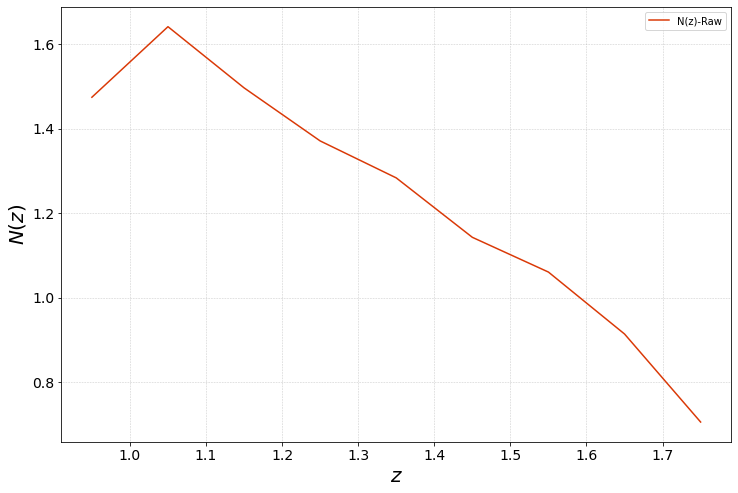

In [7]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

colors=plt.cm.turbo(np.linspace(0.99,0.01,16))
ax.plot(zz,myN(zz)/np.trapz(myN(zz),zz),label='N(z)-Raw',color=colors[2])
#ax.plot(myzz,myN(myzz)/np.trapz(myN(myzz),myzz),label='N(z)-Interpol',color=colors[3])
#ax.set_xlim(0.8, 2)
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)
ax.legend(fontsize=10,ncol=4)
#working_path='/home/rciancarella/DarkSirensStat/PlotTest/'
#plt.savefig(os.path.join(working_path+'Nz_euclidlike.pdf'))

Text(0, 0.5, '$N(z)$')

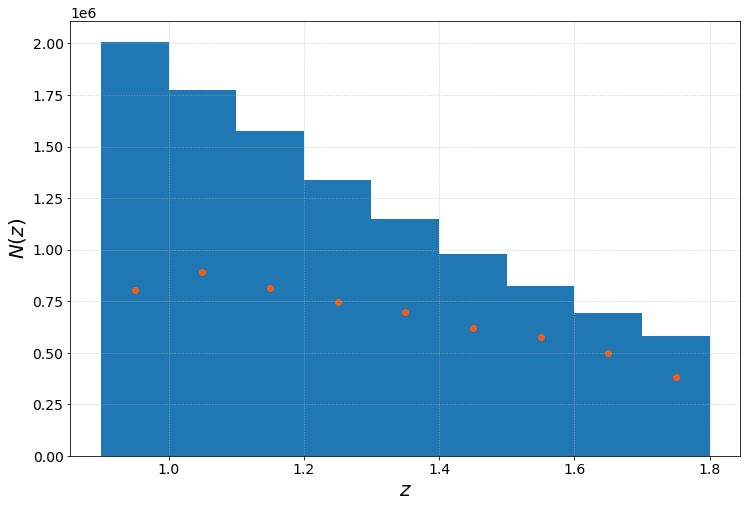

In [8]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

abs_num=values*5125*0.1
bins_of_euclid=len(zz)
ax.hist(flag_z,bins=bins_of_euclid,range=(myzz.min()-0.05,myzz.max()+0.05))
ax.scatter(zz,abs_num,label='N(z)-Interpol',color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
print(np.trapz(values*5125,zz))
tmp=flag_z[flag_z>zz.min()]
tmp=tmp[tmp<zz.max()]
print(len(tmp)/np.trapz(values*5125,zz))
print(len(tmp)/np.sum(abs_num))

# Building our Catalogue-UniformCat
First we need to generate an uniform catalogue in comoving volume. This imply a cosmology. We need a fixed and constant comoving density. The number of object in the most pupulated bin of the data must be the same as the uniform cat

In [ ]:
#first the density at the 0 bin
cutted_flag_z=flag_z[flag_z>=zz.min()-0.05]
cutted_flag_z=cutted_flag_z[cutted_flag_z<=zz.max()+0.05]
Nbin_max=abs_num.max()
index=np.where(abs_num==abs_num.max())
bin_max_vol=cosmoflag.comoving_volume(zz[index]+0.05).value-cosmoflag.comoving_volume(zz[index]-0.05).value
density=Nbin_max/bin_max_vol
tot_vol=cosmoflag.comoving_volume(zz.max()+0.05).value-cosmoflag.comoving_volume(zz.min()-0.05).value
Numb=density*tot_vol
mydcom_min=cosmoflag.comoving_distance(zz.min()-0.05).value
mydcom_max=cosmoflag.comoving_distance(zz.max()+0.05).value

In [ ]:
'''Uniform spherical distribution'''
nsamp=int(Numb+1)
#nsamp=1000
dcom_min=mydcom_min
dcom_max=mydcom_max

phi_min=0.0001#0.0001
phi_max=np.pi/2
theta_min=0.0002976218846182377
theta_max=1.570796275052059#depends on the arccos 0 to 1 is from pi/2 to 0 -1 to 1 is full range
#------------------points generator------------------
u     = np.random.uniform(0,1,size=nsamp) # uniform random vector of size nsamp

#dc_gals_all     = np.cbrt((u*dcom_min**3)+((1-u)*dcom_max**3))
dc_gals     = np.cbrt((u*dcom_min**3)+((1-u)*dcom_max**3))
phi_gals   = np.random.uniform(phi_min,phi_max,nsamp)
theta_gals = np.arccos( np.random.uniform(0,1,nsamp) )

#dc_gals=dc_gals_all[dc_gals_all>=dcom_min]
#print(len(dc_gals_all),len(dc_gals),len(dc_gals)/len(dc_gals_all))
ra_gals=ra = np.rad2deg(phi_gals)
dec_gals = np.rad2deg(0.5 * np.pi - theta_gals)

In [ ]:
print(phi_gals.min())
print(phi_gals.max())
print(theta_gals.min())
print(theta_gals.max())

In [ ]:
h=0.67
mynumevent=int(0)
myngcup=int(0)
GWGC_name='NGC'+ str(myngcup)
HyperLEDA_name=GWGC_name
MASS_XSC_name='NaN'
type_flag='G'
proxy_row={'numevent':mynumevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':0,'declination_degrees':0,'dl':0,'z':0,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':klum_mean+4,'err_app_K_mag':klum_std,
           'lum_dist_flag':3,'pec_vel_correction':0
          }

In [ ]:
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
uniform_scaled = pd.DataFrame(columns=colnames)
#glade_like.columns=colnames
uniform_scaled.head()

In [ ]:
arr=np.arange(0,len(dc_gals),dtype=int)
data=[]
tmp=[]
start_time = time.time()
print('I am Doing my best, please wait...')
with Pool(14) as p:
    tmp=p.map(GLADE_inator_volume, arr)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
uniform_scaled=uniform_scaled.append(tmp, ignore_index=True)

In [ ]:
cat_name='uniform_comoving.txt'
#uniform_scaled.to_csv(cat_name, header=None, index=None, sep=' ')

In [11]:
uniform_scaled = pd.read_csv('uniform_comoving.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
uniform_scaled.columns=colnames
uniform_scaled_z=flag['z']

FileNotFoundError: [Errno 2] No such file or directory: 'uniform_comoving.txt'

In [ ]:
zz_from_unif=uniform_scaled['z']
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


bins_of_euclid=len(zz)
ax.hist(zz_from_unif,bins=len(zz),range=(zz.min()-0.05,zz.max()+0.05))
ax.scatter(zz,abs_num,label='N(z)-Interpol',color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
n, bins, patches = plt.hist(x=zz_from_unif,bins=len(zz),range=(zz.min()-0.05,zz.max()+0.05),color='#0504aa',
                            alpha=0.7, rwidth=0.85)

In [ ]:
Pesi=n/abs_num
Pesi_interpol=interpolate.interp1d(zz,Pesi,kind='cubic',fill_value='extrapolate')
temp_zz=np.linspace(zz.min()-0.05,zz.max()+0.05,50)
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#ax.scatter(zz,abs_num,label='Pesi-Interpol',color=colors[3])
#ax.scatter(zz,n,label='Pesi-Interpol',color=colors[6])
ax.scatter(zz,Pesi,label='Pesi-Interpol',color=colors[3])
ax.plot(temp_zz,Pesi_interpol(temp_zz),label='Pesi-Interpol',color=colors[6])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
# Saving the array in a text file
#cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
#os.chdir(cat_data_path)
#np.savetxt("myzz.txt", zz)
#np.savetxt("myweights.txt", Pesi)

# Dilution of the flagship
Now, for each bin of the data, we thake that many host from the flagship, thus keeping the structure of the catalogue 

In [ ]:
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
dilution = pd.DataFrame(columns = colnames)

In [ ]:
for i in range(len(zz)):
    temp_bin=flag[flag['z']>=zz[i]-0.05]
    temp_bin=temp_bin[temp_bin['z']<=zz[i]+0.05]
    temp_bin=temp_bin.sample(round(abs_num[i]))
    dilution=dilution.append(temp_bin, ignore_index=True)

In [ ]:
dilution.shape[0]-np.sum(abs_num)

In [ ]:
diluted_zz=dilution['z']
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


bins_of_euclid=len(zz)
ax.hist(diluted_zz,bins=len(zz),range=(zz.min()-0.05,zz.max()+0.05))
ax.scatter(zz,abs_num,label='N(z)-Interpol',color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
os.chdir(cat_data_path)
dilution.to_csv('diluted_flag.txt', header=None, index=None, sep=' ')

# Adding Diluted to Comoving:Output is the Father of diluted the flagship is the mother of diluted
#uniform_comoving_father_of_diluted

In [ ]:
tmp_com = pd.read_csv('uniform_comoving_for_diluted.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
tmp_com.columns=colnames

In [ ]:
tmp_diluted = pd.read_csv('diluted_flag.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
tmp_diluted.columns=colnames

In [ ]:
diff=np.zeros(len(zz))
for i in tqdm(range(len(zz))):
    temp_bin=tmp_com[tmp_com['z']>=zz[i]-0.05]
    temp_bin=temp_bin[temp_bin['z']<=zz[i]+0.05]
    diff[i]=temp_bin.shape[0]-abs_num[i]
    sampled=temp_bin.sample(round(diff[i]))
    tmp_diluted=tmp_diluted.append(sampled, ignore_index=True)

In [ ]:
uniform_zz=tmp_com['z']
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))



ax.hist(uniform_zz,bins=len(zz),range=(zz.min()-0.05,zz.max()+0.05))
ax.scatter(zz,abs_num,label='N(z)-Interpol',color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
cat_data_path='/home/rciancarella/DarkSirensStat/data/GLADE/'
os.chdir(cat_data_path)
#tmp_diluted.to_csv('uniform_comoving_father_of_diluted.txt', header=None, index=None, sep=' ')

# 100% sure Auto-consistent generation

In [9]:
#Temporary stuff
new_cat = pd.read_csv('uniform_comoving_autoconsistent.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
new_cat.columns=colnames

In [10]:
#first the density at the 0 bin
#cutted_flag_z=flag_z[flag_z>=zz.min()-0.05]
#cutted_flag_z=cutted_flag_z[cutted_flag_z<=zz.max()+0.05]
#Nbin_max=abs_num.max()
#index=np.where(abs_num==abs_num.max())
#bin_max_vol=cosmoflag.comoving_volume(zz[index]+0.05).value-cosmoflag.comoving_volume(zz[index]-0.05).value
#density=Nbin_max/bin_max_vol
#tot_vol=cosmoflag.comoving_volume(zz.max()+0.05).value-cosmoflag.comoving_volume(zz.min()-0.05).value
#Numb=density*tot_vol

print(new_cat.shape[0],new_cat['z'].min(),new_cat['z'].max())
mydcom_min=cosmoflag.comoving_distance(new_cat['z'].min()).value
mydcom_max=cosmoflag.comoving_distance(new_cat['z'].max()).value

6500000 0.9000001039126828 1.799999998727529


In [11]:
'''Uniform spherical distribution'''
'''We can have arbitrary absolute number of object so nsamp can be whatever'''
#fixed_density=1.5e-05#
#nsamp=fixed_density*tot_vol
nsamp=new_cat.shape[0]+2*2156000#int(6_500_000)#int(Numb+1)
#nsamp=1000
z_inf_cat=0.85#0.79
z_sup_cat=1.15#2
dcom_min=cosmoflag.comoving_distance(z_inf_cat).value#mydcom_min
dcom_max=cosmoflag.comoving_distance(z_sup_cat).value#mydcom_max

#tot_vol=cosmoflag.comoving_volume(zz.max()+0.05).value-cosmoflag.comoving_volume(zz.min()-0.05).value
phi_min=0.0001#0.0001
phi_max=np.pi/2
theta_min=0.0002976218846182377
theta_max=1.570796275052059#depends on the arccos 0 to 1 is from pi/2 to 0 -1 to 1 is full range
#------------------points generator------------------
u     = np.random.uniform(0,1,size=nsamp) # uniform random vector of size nsamp
dc_gals_all     = np.cbrt((u*0**3)+((1-u)*dcom_max**3))
#dc_gals     = np.cbrt((u*dcom_min**3)+((1-u)*dcom_max**3))
phi_gals   = np.random.uniform(phi_min,phi_max,nsamp)
theta_gals = np.arccos( np.random.uniform(0,1,nsamp) )

dc_gals=dc_gals_all[dc_gals_all>=dcom_min]
#print(len(dc_gals_all),len(dc_gals),len(dc_gals)/len(dc_gals_all))
ra_gals=ra = np.rad2deg(phi_gals)
dec_gals = np.rad2deg(0.5 * np.pi - theta_gals)
print(len(dc_gals))
print(100*len(dc_gals)/len(dc_gals_all))

5241926
48.48248242693304


In [12]:
#print(np.min(theta_gals),np.max(theta_gals))
#--------------Volume and Density----------------------
delta_phi=np.max(phi_gals)-np.min(phi_gals)
theta_part=np.cos(np.min(theta_gals))-np.cos(np.max(theta_gals))
zmin=new_cat['z'].min()
zmax=new_cat['z'].max()
integrand=lambda x:clight*(cosmoflag.comoving_distance(x).value)**2/(cosmoflag.H(x).value)
z_part=integrate.quad(integrand,zmin,zmax)[0]
#print(delta_phi,theta_part,z_part)
Volume=delta_phi*theta_part*z_part
print('Volume of Uniform {} Gpc^3'.format(Volume/1000**3))
Nobj=len(dc_gals)
Density=Nobj/Volume
print('Density of Uniform {} #/Mpc^3'.format(Density))
print(zmin,zmax)

Volume of Uniform 49.69104446317754 Gpc^3
Density of Uniform 0.00010549035659502819 #/Mpc^3
0.9000001039126828 1.799999998727529


In [13]:
h=0.67
mynumevent=int(0)
myngcup=int(0)
GWGC_name='NGC'+ str(myngcup)
HyperLEDA_name=GWGC_name
MASS_XSC_name='NaN'
type_flag='G'
proxy_row={'numevent':mynumevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':0,'declination_degrees':0,'dl':0,'z':0,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':klum_mean+4,'err_app_K_mag':klum_std,
           'lum_dist_flag':3,'pec_vel_correction':0
          }

In [14]:
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
uniform_scaled = pd.DataFrame(columns=colnames)
#glade_like.columns=colnames
uniform_scaled.head()

,numevent,GWGC_name,HyperLEDA_name,2MASS_XSC_name,SDSS-DR12Q_name,type_flag,right_ascension_degrees,declination_degrees,dl,err_lum_dist,...,err_app_B_mag,abs_B_mag,app_J_mag,err_app_J_mag,app_H_mag,err_app_H_mag,app_K_mag,err_app_K_mag,lum_dist_flag,pec_vel_correction


In [15]:
arr=np.arange(0,len(dc_gals),dtype=int)
data=[]
tmp=[]
start_time = time.time()
print('I am Doing my best, please wait...')
with Pool(14) as p:
    tmp=p.map(GLADE_inator_volume, arr)
print("--- %s seconds ---" % (time.time() - start_time))

I am Doing my best, please wait...
--- 727.862065076828 seconds ---


In [16]:
uniform_scaled=uniform_scaled.append(tmp, ignore_index=True)

In [17]:
cat_name='genova_uniform_samezasminimal.txt'
uniform_scaled.to_csv(cat_name, header=None, index=None, sep=' ')

In [ ]:
uniform_scaled = pd.read_csv('uniform_comoving_autoconsistent.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
uniform_scaled.columns=colnames

In [ ]:
zz_from_unif=uniform_scaled['z']
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#bin~0.018
my_bins=50

ax.hist(zz_from_unif,bins=my_bins,range=(zz_from_unif.min(),zz_from_unif.max()))
#ax.hist(zz_from_generated,bins=my_bins,range=(uniform_scaled.min(),uniform_scaled.max()))
#ax.scatter(zz,abs_num,label='N(z)-Interpol',color=colors[3])
#plt.xscale('log')
#plt.yscale('log')
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
print(len(zz_from_unif))
mindec=uniform_scaled['declination_degrees'].min()
maxdec=uniform_scaled['declination_degrees'].max()
minra=uniform_scaled['right_ascension_degrees'].min()
maxra=uniform_scaled['right_ascension_degrees'].max()
print(mindec,maxdec,minra,maxra)

In [ ]:
thmin,phimin=th_phi_from_ra_dec(minra,maxdec/2)
thmax,phimax=th_phi_from_ra_dec(maxra,mindec)
print(thmin,thmax,phimin,phimax)

In [ ]:
#-----------rejection-stuff------------
def sample(g,xmin,xmax):
    x = np.linspace(xmin,xmax,1000000)
    y = g(x)                        # probability density function, pdf
    cdf_y = np.cumsum(y)            # cumulative distribution function, cdf
    cdf_y = cdf_y/cdf_y.max()       # takes care of normalizing cdf to 1.0
    inverse_cdf = interpolate.interp1d(cdf_y,x,fill_value="extrapolate")# this is a function
    #inverse_cdf = np.interp(0,cdf_y,x) #this works but it is not a function
    return inverse_cdf
def return_samples(f,xmin,xmax,N=1000000):
    # let's generate some samples according to the chosen pdf, f(x)
    uniform_samples = random(int(N))       
    required_samples = sample(f,xmin,xmax)(uniform_samples)
    return required_samples

'''Now each host should be in a simple one-to-one ralation with it's redshift: 
the index of the constructed redshift array should be the numevent or the line-1.
Use this relation to extract the host''' 

my_zmin=zz_from_unif.min()
my_zmax=zz_from_unif.max()
nsamp=int(6_500_000)
my_totnumb=int(1+nsamp/12)

print(my_totnumb)
target_dist= lambda z: 1/(z**2)
extracted=return_samples(target_dist,my_zmin,my_zmax,my_totnumb)
n, bins, patches = plt.hist(x=extracted,bins=my_bins,range=(zz_from_unif.min(),zz_from_unif.max()),color='#0504aa',
                            alpha=0.7, rwidth=0.85)
print(my_totnumb/uniform_scaled.shape[0])

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))


#bins_of_euclid=len(zz)
ax.hist(zz_from_unif,bins=my_bins,range=(my_zmin,my_zmax))
ax.hist(extracted,bins=my_bins,range=(my_zmin,my_zmax))
#ax.scatter(zz,abs_num,label='N(z)-Interpol',color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
my_generated = pd.DataFrame(columns=colnames)
#glade_like.columns=colnames
my_generated.head()

In [ ]:
#Temporary stuff
old_one = pd.read_csv('gw23cat_uniform_30_1oct.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
old_one.columns=colnames

In [ ]:
#Temporary stuff
new_one = pd.read_csv('uniform_comoving_autoconsistent.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
new_one.columns=colnames

In [ ]:
#Temporary stuff
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

my_bins=50
#bins_of_euclid=len(zz)
ax.hist(new_one['z'],bins=my_bins,range=(new_one['z'].min(),new_one['z'].max()))
ax.hist(old_one['z'],bins=my_bins,range=(new_one['z'].min(),new_one['z'].max()))

#ax.scatter(zz,abs_num,label='N(z)-Interpol',color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
print(len(bins))
bin_width=bins[1]-bins[0]
print(bin_width)

In [ ]:
for i in tqdm(range(my_bins)):
    temp_bin=uniform_scaled[uniform_scaled['z']>=bins[i]]
    temp_bin=temp_bin[temp_bin['z']<bins[i+1]]
    sampled=temp_bin.sample(round(n[i]))
    my_generated=my_generated.append(sampled, ignore_index=True)

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

#ax.set_yscale('log')
#ax.set_xscale('log')

ax.hist(zz_from_unif,bins=my_bins,range=(my_zmin,my_zmax))
ax.hist(my_generated['z'],bins=my_bins,range=(my_zmin,my_zmax))
#ax.scatter(zz,abs_num,label='N(z)-Interpol',color=colors[3])
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N(z)$', fontsize=20)

In [ ]:
cat_name='selected_autoconsistent_halved.txt'
my_generated.to_csv(cat_name, header=None, index=None, sep=' ')

In [ ]:
fraction=my_generated.shape[0]/uniform_scaled.shape[0]
print(fraction)

# Test: Old vs New Catalogue

In [ ]:
cat1= pd.read_csv('gw23cat_uniform_30_1oct.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
cat1.columns=colnames

In [ ]:
cat2 = pd.read_csv('uniform_comoving_autoconsistent.txt', sep=" ", header=None)
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
cat2.columns=colnames
#gw23cat_uniform_30_1oct
#uniform_comoving_autoconsistent
#just_for_test
#just_for_test_new

In [ ]:
'''Weights'''
phi_gals_cat1 = np.deg2rad(cat1['right_ascension_degrees'])
phi_gals_cat2 = np.deg2rad(cat2['right_ascension_degrees'])

theta_gals_cat1 = (0.5 * np.pi - np.deg2rad(cat1['declination_degrees']))
theta_gals_cat2 = (0.5 * np.pi - np.deg2rad(cat2['declination_degrees']))

costheta_cat1=np.cos(theta_gals_cat1)
costheta_cat2=np.cos(theta_gals_cat2)
#invertire queste
n_cat1, bins, patches = plt.hist(x=costheta_cat1,bins=50,range=(costheta_cat1.min(),costheta_cat1.max()),color='#671D5B',
                            alpha=0.7, rwidth=0.85)

n_cat2, bins, patches = plt.hist(x=costheta_cat2,bins=50,range=(costheta_cat2.min(),costheta_cat2.max()),color='#17EA1E',
                            alpha=0.7, rwidth=0.85)

In [ ]:
n_cat1, bins, patches = plt.hist(x=phi_gals_cat1,bins=50,range=(phi_gals_cat1.min(),phi_gals_cat1.max()),color='#671D5B',
                            alpha=0.7, rwidth=0.85)

n_cat2, bins, patches = plt.hist(x=phi_gals_cat2,bins=50,range=(phi_gals_cat2.min(),phi_gals_cat2.max()),color='#17EA1E',
                            alpha=0.7, rwidth=0.85)

In [ ]:
n_cat1, bins, patches = plt.hist(x=cat1['z'],bins=50,range=(cat2['z'].min(),cat2['z'].max()),color='#671D5B',
                           alpha=0.7, rwidth=0.85)

n_cat2, bins, patches = plt.hist(x=cat2['z'],bins=50,range=(cat2['z'].min(),cat2['z'].max()),color='#17EA1E',
                            alpha=0.7, rwidth=0.85)

In [ ]:
norm=n_cat1[0]/n_cat2[0]#cat2.shape[0]/cat1.shape[0]
bin_width=bins[1]-bins[0]
x=bins[0:-1]+bin_width/2
normed_nzcat1=n_cat1/np.trapz(n_cat1,x)
normed_nzcat2=n_cat2/np.trapz(n_cat2,x)
#Pesi=(n_uniform-(n_myzz*norm))/n_myzz
Pesi=(normed_nzcat2)/normed_nzcat1
#error on the ratio
#absolute errors
cat1_error=np.sqrt(n_cat1)
cat2_error=np.sqrt(n_cat2*norm)
#relative errors
cat1_error_rel=cat1_error/n_cat1
cat2_error_rel=cat2_error/(n_cat2*norm)
#adding relative errors
tot_errors_rel=cat1_error_rel+cat2_error_rel
tot_errors=tot_errors_rel*Pesi
#print(Pesi,n_uniform,n_myzz)
print(cat1.shape[0],cat2.shape[0],Pesi[0],norm)
print(Pesi)
print((Pesi-1)/tot_errors)
print(n_cat1[0],n_cat2[0])

In [ ]:
#np.savetxt("catgw23_run30_z.txt", bins[0:-1]+bin_width/2)
#np.savetxt("catgw23_run30_w.txt", Pesi)
#zz=np.loadtxt('/home/rciancarella/DarkSirensStat/data/GLADE/catgw23_run30_z.txt')
#ww=np.loadtxt('/home/rciancarella/DarkSirensStat/data/GLADE/catgw23_run30_w.txt')

In [ ]:
#bin_width=bins[1]-bins[0]
#stat_weights=interpolate.interp1d( bins[0:-1]+bin_width/2,Pesi,kind='cubic',fill_value='extrapolate')
#x=np.linspace(bins[0]+bin_width/2,bins[-1]+bin_width/2,1000)
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))
x=bins[0:-1]+bin_width/2
#ax.plot(zz,ww,label='interpol',color=colors[12])
#ax.scatter(x,(Pesi-Pesi[0])/tot_errors,label='z-Pesi',color='k')
#plt.errorbar(x, (Pesi-norm)/tot_errors, yerr=tot_errors, fmt="+")
ax.set_ylim([-3.5,3.5])
ax.fill_between(x,1,-1,alpha=0.35, color='palegreen')
ax.fill_between(x,2,1,alpha=0.35, color='magenta')
ax.fill_between(x,-2,-1,alpha=0.35, color='magenta')
ax.fill_between(x,3,2,alpha=0.35, color='cyan')
ax.fill_between(x,-3,-2,alpha=0.35, color='cyan')
ax.scatter(x,(Pesi-1)/tot_errors,label='z-Pesi',color='k')
#plt.axhline(y=Pesi[0], color='k', linestyle='-')
plt.axhline(y=0, color='k', linestyle='-')
plt.title('OldCat_VS_NewCat',fontsize=20)
ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$W_s(z)$', fontsize=20)
working_path='/home/rciancarella/DarkSirensStat/PlotTest/'
plt.savefig(os.path.join(working_path+'OldCat_VS_OldProcedure.pdf'))

In [ ]:
print(np.mean((Pesi-1)/tot_errors))
print(np.sum((Pesi-1)/1))

In [ ]:
x=bins[0:-1]+bin_width/2
normed_nzcat1=n_cat1/np.trapz(n_cat1,x)
normed_nzcat2=n_cat2/np.trapz(n_cat2,x)

In [ ]:
fig, ax = plt.subplots(1, figsize=(12,8)) #crea un tupla che poi è più semplice da gestire
ax.tick_params(axis='both', which='major', labelsize=14)
ax.yaxis.get_offset_text().set_fontsize(14)
ax.grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo
colors=plt.cm.turbo(np.linspace(0.99,0.01,16))

ax.plot(x,normed_nzcat1,label='N(z)_cat1',color=colors[3])
ax.plot(x,normed_nzcat2,label='N(z)_cat2',color=colors[12])
ax.legend()

ax.set_xlabel(r'$z$', fontsize=20)
ax.set_ylabel(r'$N_i(z)$', fontsize=20)

# Cat from minimal example

In [ ]:
#-----------filler-------------------
def GLADE_inator_volume(iterations):
#for i in tqdm(range(flagship.shape[0])):
#for i in range(iterations):
    i=iterations
    numevent=mynumevent+i
    ngcup=myngcup+i
    GWGC_name='NGC'+ str(ngcup)
    HyperLEDA_name=GWGC_name
    ra_gal=ra_gals[i]
    dec_gal=dec_gals[i]
    #dl=dl_gals[i]
    #dc=dc_gals[i]
    #----------z----------------------
    #zz=z_from_dL(dl)
    zz=z_gals[i]
    dc=cosmoflag.comoving_distance(zz).value
    dl=(1+zz)*dc
    #zz=cosmoflag.luminosity_distance(z_min).value
    temp_k_lum=np.random.normal(loc=klum_mean,scale=2*klum_std)
    #----------row to append---------------------
    proxy_row={'numevent':numevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':ra_gal,'declination_degrees':dec_gal,'dl':dl,'z':zz,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':temp_k_lum,'err_app_K_mag':klum_std,
           'lum_dist_flag':3,'pec_vel_correction':0
          }
    return proxy_row

In [ ]:
phi_gals=np.loadtxt('/home/rciancarella/DarkSirensStat/ProxyGenerator/Extractedcat_phigals.txt')
theta_gals=np.loadtxt('/home/rciancarella/DarkSirensStat/ProxyGenerator/Extractedcat_thetagals.txt')
z_gals=np.loadtxt('/home/rciancarella/DarkSirensStat/ProxyGenerator/Extractedcat_zgals.txt')
dc_gals=np.loadtxt('/home/rciancarella/DarkSirensStat/ProxyGenerator/Extractedcat_dcgals.txt')

In [ ]:
ra_gals=np.rad2deg(phi_gals)
dec_gals=np.rad2deg(0.5 * np.pi - theta_gals)
print(len(ra_gals),len(dec_gals),len(z_gals),len(dc_gals))

In [ ]:
h=0.67
mynumevent=int(0)
myngcup=int(0)
GWGC_name='NGC'+ str(myngcup)
HyperLEDA_name=GWGC_name
MASS_XSC_name='NaN'
type_flag='G'
proxy_row={'numevent':mynumevent,'GWGC_name':GWGC_name,'HyperLEDA_name':HyperLEDA_name,
           '2MASS_XSC_name':MASS_XSC_name,'SDSS-DR12Q_name':'NaN','type_flag':type_flag,
           'right_ascension_degrees':0,'declination_degrees':0,'dl':0,'z':0,
           'app_B_mag':mean_app_B_mag,'err_app_B_mag':err_app_B_mag,'abs_B_mag':'NaN',
           'app_J_mag':mean_app_J_mag,'err_app_J_mag':err_app_J_mag,
           'app_H_mag':mean_app_H_mag,'err_app_H_mag':err_app_H_mag,
           'app_K_mag':klum_mean+4,'err_app_K_mag':klum_std,
           'lum_dist_flag':3,'pec_vel_correction':0
          }

In [ ]:
colnames=['numevent','GWGC_name','HyperLEDA_name','2MASS_XSC_name','SDSS-DR12Q_name','type_flag','right_ascension_degrees',
          'declination_degrees','dl','err_lum_dist','z','app_B_mag','err_app_B_mag','abs_B_mag','app_J_mag',
          'err_app_J_mag','app_H_mag','err_app_H_mag','app_K_mag','err_app_K_mag','lum_dist_flag','pec_vel_correction'
          ]
uniform_scaled = pd.DataFrame(columns=colnames)
#glade_like.columns=colnames
uniform_scaled.head()

In [ ]:
arr=np.arange(0,len(z_gals),dtype=int)
data=[]
tmp=[]
start_time = time.time()
print('I am Doing my best, please wait...')
with Pool(14) as p:
    tmp=p.map(GLADE_inator_volume, arr)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
uniform_scaled=uniform_scaled.append(tmp, ignore_index=True)

In [ ]:
cat_name='MinimalCat.txt'
uniform_scaled.to_csv(cat_name, header=None, index=None, sep=' ')